In [5]:
import jax
import jax.numpy as jnp
import numpy as np
import timeit

import ot

from find_indices_cython import find_indices

In [6]:
# Import the Cython-optimized function

# Convert the Cython function to a JAX-compatible function
def find_indices_jax(X, Y):
    X_np = jax.device_get(X)
    Y_np = jax.device_get(Y)
    result = find_indices(X_np, Y_np)
    return jnp.array(result)


find_indices_jax_cython = jax.jit(find_indices_jax)

In [7]:
import numpy as np
import timeit

# Cython-optimized function
def find_indices_cython(X, Y):
    return find_indices(X, Y)

# Ordinary Pythonic version
def find_indices_python(X, Y):
    result = []
    i = 1
    j = 1

    while i < X.shape[0] and j < Y.shape[0]:
        if X[i] > Y[j-1] and Y[j] > X[i-1]:
            result.append((i, j))
            i += 1
        elif X[i] <= Y[j-1]:
            i += 1
        else:
            j += 1

    return result


# Pure NumPy version
def find_indices_numpy(X, Y):
    indices = np.nonzero((X[:,None] > Y[None,:]) & (Y[None,:] > X[:,None]))
    return indices

# Compiled JAX version  
from jax import jit
import jax.numpy as jnp
def find_indices_jax_2(X, Y):
    indices = jnp.nonzero((X[:,None] > Y[None,:]) & (Y[None,:] > X[:,None]), size = 2*len(X))
    return indices
find_indices_jax_2 = jit(find_indices_jax_2)


@jax.jit
def find_indices_jax(X, Y):


    def condition(state):
        step, i, j, _ = state
        return (jax.lax.lt(i, X_length) & jax.lax.lt(j, Y_length))

    def body(state):
        step, i, j, result = state
        x_gt_y = jnp.take(X, i) > jnp.take(Y, j - 1)
        y_gt_x = jnp.take(Y, j) > jnp.take(X, i - 1)

        # Conditionals to update i and j
        advance_i = (x_gt_y & y_gt_x)
        advance_i_2 = ~advance_i &  (jnp.take(X, i) >= jnp.take(Y, j-1))
        advance_j = ~advance_i & ~advance_i_2

        next_i = i + jax.lax.select(advance_i | advance_i_2, 1, 0)
        next_j = j + jax.lax.select(advance_j, 1, 0)
        next_result = jax.lax.cond(
            x_gt_y & y_gt_x,
            lambda _: jnp.array([i, j], dtype=jnp.int32),
            lambda _: jnp.array([-1, -1], dtype=jnp.int32),
            None
        )
        next_result = result.at[step].set(next_result)
        return (step + 1, next_i, next_j, next_result)

    step = 0
    X_length, Y_length = X.shape[0], Y.shape[0]
    max_length = X_length + Y_length
    initial_state = (step, 1, 1, jnp.full((max_length, 2), -1, dtype=jnp.int32), )

    _, _, _, final_result = jax.lax.while_loop(condition, body, initial_state)

    return final_result



# Sample data -- random, sorted and np.float32
X = np.sort(np.random.randn(100).astype(np.float32))
Y = np.sort(np.random.randn(100).astype(np.float32))

print(find_indices_jax(X,Y))
print(find_indices_jax_2(X,Y))

functions = [find_indices_cython, find_indices_python, find_indices_numpy, find_indices_jax, find_indices_jax_2]
for f in functions:
    time = timeit.timeit(lambda: f(X, Y), number=100)
    print(f"{f.__name__} Time: {time:.6f} seconds")



# Array of all functions to test



[[ 1  1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 [-1 -1]
 

In [15]:

# Get the average and standard deviation runtime for each function as a function of the input size
def get_runtimes(func, sizes, verbose=True):
    runtimes = []
    for size in sizes:
        X = np.sort(np.random.randn(size).astype(np.float32))
        Y = np.sort(np.random.randn(size).astype(np.float32))
        if verbose:
            print(f"Running {func.__name__} with size {size}...")

        # Get the array of runtimes across 10 runs
        runtime = timeit.timeit(lambda: func(X, Y), number=10)
        runtimes.append(runtime)
        if verbose:
            print(f"Finished {func.__name__} with size {size} in {runtime:.6f} seconds.")
    return np.array(runtimes)

# functio to test the runtime of ot.emd
def test_emd(n, verbose=True):
    runtimes = []
    for size in n:

        mu_s = np.array([0, 0])
        cov_s = np.array([[1, 0], [0, 1]])

        mu_t = np.array([4, 4])
        cov_t = np.array([[1, -.8], [-.8, 1]])

        xs = ot.datasets.make_2D_samples_gauss(size, mu_s, cov_s)
        xt = ot.datasets.make_2D_samples_gauss(size, mu_t, cov_t)


        a, b = np.ones((size,)) / size, np.ones((size,)) / size  # uniform distribution on samples

        # loss matrix
        M = ot.dist(xs, xt)
        

        if verbose:
            print(f"Running {test_emd.__name__} with size {size}...")

        # Get the array of runtimes across 10 runs
        runtime = timeit.timeit(lambda: ot.emd(a, b, M), number=10)
        runtimes.append(runtime)
        if verbose:
            print(f"Finished {test_emd.__name__} with size {size} in {runtime:.6f} seconds.")


    return runtimes


sizes = np.logspace(1, 7, 20).astype(np.int32)
cython_runtimes = get_runtimes(find_indices_cython, sizes, verbose=True)
python_runtimes = get_runtimes(find_indices_python, sizes[:15], verbose=True)
numpy_runtimes = get_runtimes(find_indices_numpy, sizes[:10], verbose=True)
jax_runtimes = get_runtimes(find_indices_jax, sizes, verbose=True)
jax_2_runtimes = get_runtimes(find_indices_jax_2, sizes[:10], verbose=True)
POT_runtimes = test_emd(sizes[:8])

# make array of all runtimes
all_runtimes = np.array([cython_runtimes, python_runtimes, numpy_runtimes, jax_runtimes, jax_2_runtimes, POT_runtimes])
sizes_array = np.array([sizes, sizes[:15], sizes[:10], sizes, sizes[:10], sizes[:8]])

Running find_indices_cython with size 10...
Finished find_indices_cython with size 10 in 0.000014 seconds.
Running find_indices_cython with size 20...
Finished find_indices_cython with size 20 in 0.000015 seconds.
Running find_indices_cython with size 42...
Finished find_indices_cython with size 42 in 0.000022 seconds.
Running find_indices_cython with size 88...
Finished find_indices_cython with size 88 in 0.000041 seconds.
Running find_indices_cython with size 183...
Finished find_indices_cython with size 183 in 0.000077 seconds.
Running find_indices_cython with size 379...
Finished find_indices_cython with size 379 in 0.000198 seconds.
Running find_indices_cython with size 784...
Finished find_indices_cython with size 784 in 0.000545 seconds.
Running find_indices_cython with size 1623...
Finished find_indices_cython with size 1623 in 0.001200 seconds.
Running find_indices_cython with size 3359...
Finished find_indices_cython with size 3359 in 0.002328 seconds.
Running find_indices_cy

/tmp/ipykernel_11668/1511081546.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_runtimes = np.array([cython_runtimes, python_runtimes, numpy_runtimes, jax_runtimes, jax_2_runtimes, POT_runtimes])
/tmp/ipykernel_11668/1511081546.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sizes_array = np.array([sizes, sizes[:15], sizes[:10], sizes, sizes[:10], sizes[:8]])


Cython exponent: 0.991 ± 0.005
Python exponent: 1.045 ± 0.004
NumPy exponent: 2.131 ± 0.002
JAX exponent: 1.015 ± 0.006
POT exponent: 1.080 ± 0.032


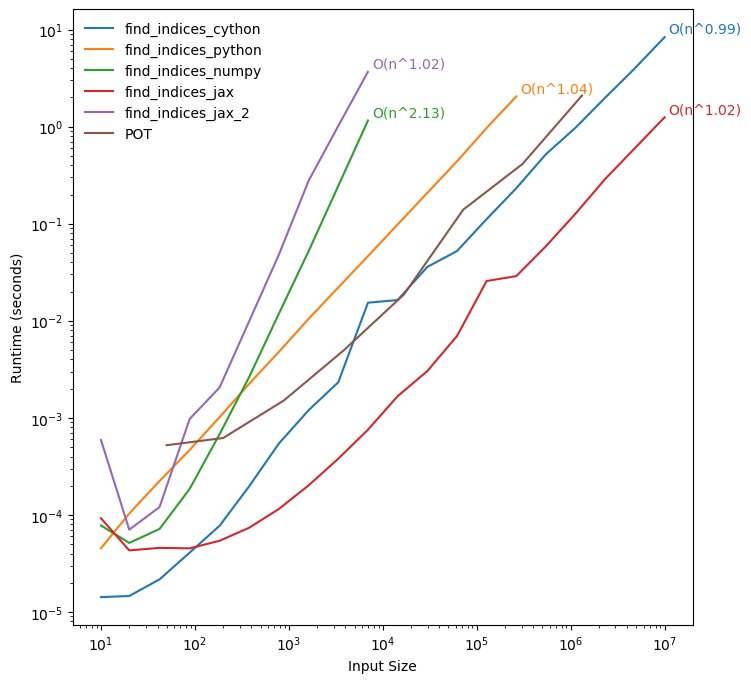

In [16]:
# Do power law fits and extract the exponents with uncertainties
from scipy.optimize import curve_fit

def power_law(x, a, b):
    return a * x**b

def fit_power_law(x, y):
    popt, pcov = curve_fit(power_law, x, y)
    return popt, np.sqrt(np.diag(pcov))

cython_exponent, cython_exponent_err = fit_power_law(sizes, cython_runtimes)
python_exponent, python_exponent_err = fit_power_law(sizes[:15], python_runtimes)
numpy_exponent, numpy_exponent_err = fit_power_law(sizes[:10], numpy_runtimes)
jax_exponent, jax_exponent_err = fit_power_law(sizes, jax_runtimes)
jax_2_exponent, jax_2_exponent_err = fit_power_law(sizes[:10], jax_2_runtimes)
POT_exponent, POT_exponent_err = fit_power_law(sizes[:8]**2/2, POT_runtimes)

exponents = [cython_exponent, python_exponent, numpy_exponent, jax_exponent, jax_exponent, POT_exponent]

print(f"Cython exponent: {cython_exponent[1]:.3f} ± {cython_exponent_err[1]:.3f}")
print(f"Python exponent: {python_exponent[1]:.3f} ± {python_exponent_err[1]:.3f}")
print(f"NumPy exponent: {numpy_exponent[1]:.3f} ± {numpy_exponent_err[1]:.3f}")
print(f"JAX exponent: {jax_exponent[1]:.3f} ± {jax_exponent_err[1]:.3f}")
print(f"POT exponent: {POT_exponent[1]:.3f} ± {POT_exponent_err[1]:.3f}")

# Plot the average runtimes with error bars to show the standard deviation

import matplotlib.pyplot as plt



plt.figure(figsize=(8, 8))

#Choose pleasing colors
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]

for i in range(len(all_runtimes)-1):
    plt.errorbar(sizes_array[i], all_runtimes[i], label=functions[i].__name__, color=colors[i])

    # Add text near the line with O(n^exponent) notation in the same color
    x_test_position = sizes_array[i][-1] * 1.1
    y_text_position = all_runtimes[i][-1] * 1.1
    plt.text(x_test_position, y_text_position, f"O(n^{exponents[i][1]:.2f})", color=colors[i])

# Plot POT separately since the scaling is different
plt.errorbar(sizes[:8]**2 / 2, POT_runtimes, label="POT", color = colors[-1])

plt.xlabel("Input Size")
plt.ylabel("Runtime (seconds)")
plt.legend(frameon = False)

# Add the power law exponent near each line with O(n^exponent) notation in the same color


# plt.text(1e3, 1e-3, f"O(n^{cython_exponent[1]:.2f})", color="C0")
# plt.text(1e3, 1e-2, f"O(n^{python_exponent[1]:.2f})", color="C1")
# plt.text(1e3, 1e-1, f"O(n^{numpy_exponent[1]:.2f})", color="C2")
# plt.text(1e3, 1e0, f"O(n^{jax_exponent[1]:.2f})", color="C3")
# plt.text(1e3, 1e1, f"O(n^{POT_exponent[1]:.2f})", color="C4")

plt.xscale("log")
plt.yscale("log")








131 ms ± 9.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


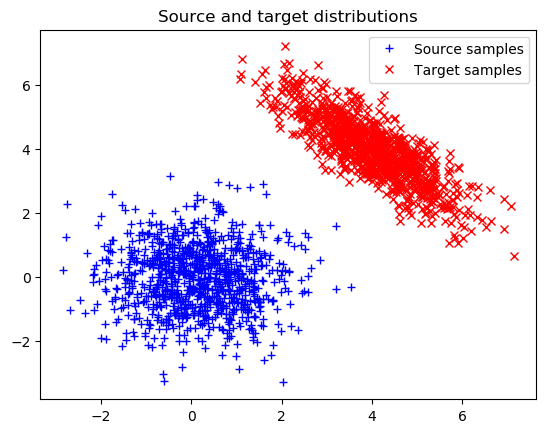

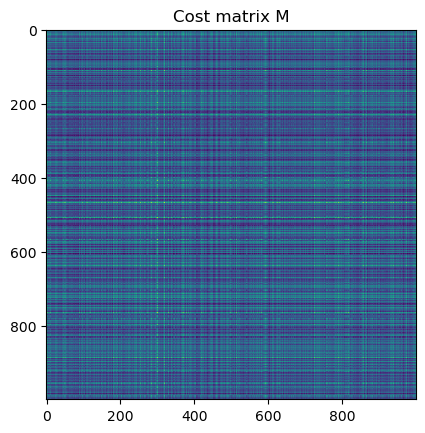

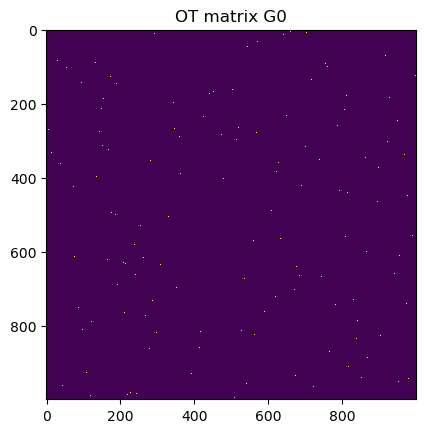

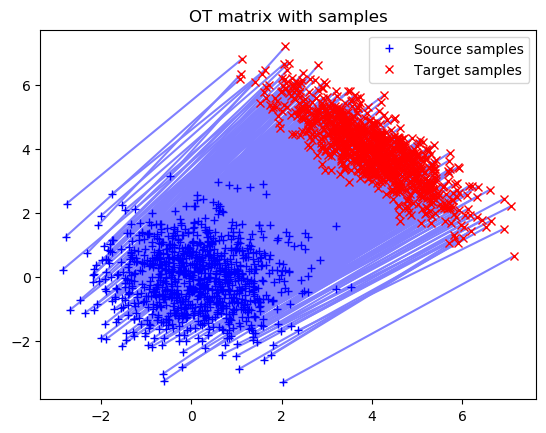

In [ ]:
import ot.plot

n = 1000  # nb samples

mu_s = np.array([0, 0])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

xs = ot.datasets.make_2D_samples_gauss(n, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t)

a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

# loss matrix
M = ot.dist(xs, xt)


plt.figure(1)
plt.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
plt.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
plt.legend(loc=0)
plt.title('Source and target distributions')

plt.figure(2)
plt.imshow(M, interpolation='nearest')
plt.title('Cost matrix M')

G0 = ot.emd(a, b, M)

plt.figure(3)
plt.imshow(G0, interpolation='nearest')
plt.title('OT matrix G0')

plt.figure(4)
ot.plot.plot2D_samples_mat(xs, xt, G0, c=[.5, .5, 1])
plt.plot(xs[:, 0], xs[:, 1], '+b', label='Source samples')
plt.plot(xt[:, 0], xt[:, 1], 'xr', label='Target samples')
plt.legend(loc=0)
plt.title('OT matrix with samples')


# functio to test the runtime of ot.emd
def test_emd(n):
    mu_s = np.array([0, 0])
    cov_s = np.array([[1, 0], [0, 1]])

    mu_t = np.array([4, 4])
    cov_t = np.array([[1, -.8], [-.8, 1]])

    xs = ot.datasets.make_2D_samples_gauss(n, mu_s, cov_s)
    xt = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t)

    a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

    # loss matrix
    M = ot.dist(xs, xt)
    return ot.emd(a, b, M)

%timeit test_emd(1000)

In [ ]:
# Use jax to vmap each function and test

import jax.numpy as jnp
from jax import vmap

# jax_find_indices_cython = vmap(find_indices_cython, in_axes=(0, None))
jax_find_indices_python = vmap(find_indices_python, in_axes=(0, None))
jax_find_indices_numpy = vmap(find_indices_numpy, in_axes=(0, None))

# jax_cython_runtimes = get_runtimes(jax_find_indices_cython, sizes, verbose=False)
jax_python_runtimes = get_runtimes(jax_find_indices_python, sizes[:10], verbose=False)
jax_numpy_runtimes = get_runtimes(jax_find_indices_numpy, sizes[:10], verbose=False)



IndexError: tuple index out of range